In [1]:
%load_ext autoreload
%autoreload 2

# I have experienced stability issues with float32.
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from libretions.channels.fm97 import Na, K, KA, Ca, Leak

import jaxley as jx

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-01-18 21:33:33.990767: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: AMD Radeon Pro 5500M

systemMemory: 16.00 GB
maxCacheSize: 1.99 GB



Text(0.5, 1.0, 'Na current')

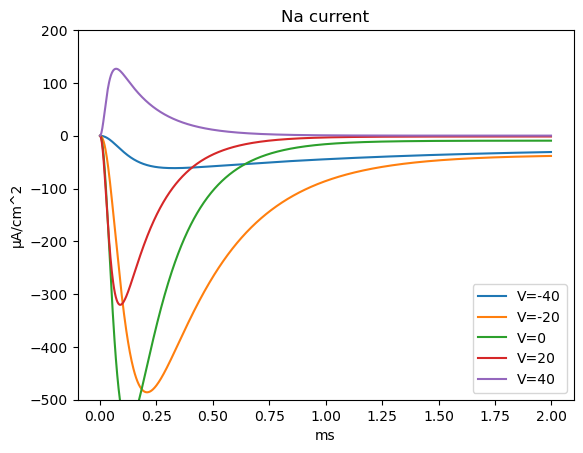

In [3]:
T = 1000
dt = 0.002

for V in [-40, -20, 0, 20, 40]:
    I = jnp.array(Na().VClamp(Vh=-65, V=V, T=T, dt=dt))
    plt.plot(jnp.arange(T) * dt, I, label=f"V={V}")
    plt.xlabel("ms")
    plt.ylabel("μA/cm^2")
    plt.ylim(-500, 200)
plt.legend()
plt.title("Na current")

Text(0.5, 1.0, 'Delayed Rectifier (K channel)')

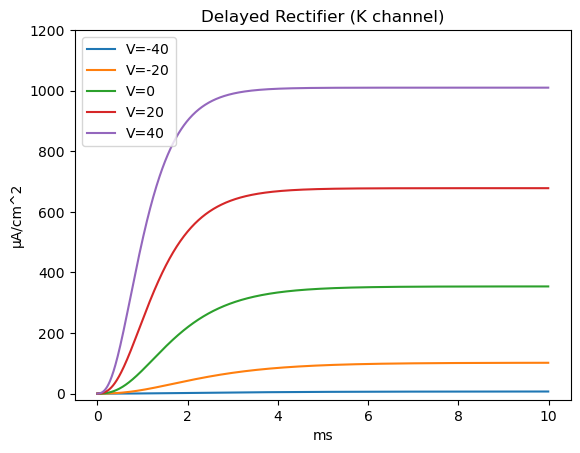

In [4]:
T = 1000
dt = 0.01

for V in [-40, -20, 0, 20, 40]:
    I = jnp.array(K().VClamp(Vh=-65, V=V, T=T, dt=dt))
    plt.plot(jnp.arange(T) * dt, I, label=f"V={V}")
    plt.xlabel("ms")
    plt.ylabel("μA/cm^2")
    plt.ylim(-20, 1200)
plt.legend()
plt.title("Delayed Rectifier (K channel)")

Text(0.5, 1.0, 'KA current')

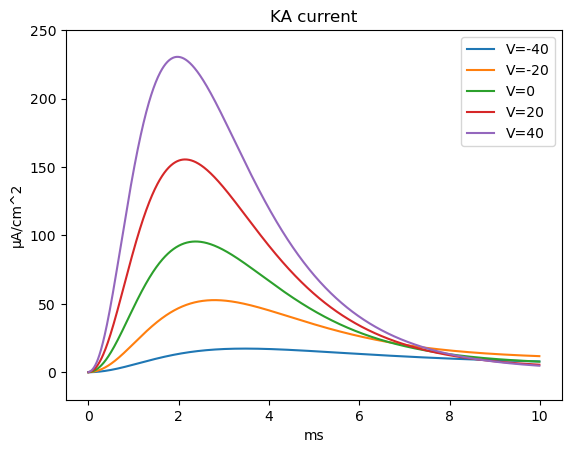

In [5]:
T = 1000
dt = 0.01

for V in [-40, -20, 0, 20, 40]:
    I = jnp.array(KA().VClamp(Vh=-65, V=V, T=T, dt=dt))
    plt.plot(jnp.arange(T) * dt, I, label=f"V={V}")
    plt.xlabel("ms")
    plt.ylabel("μA/cm^2")
    plt.ylim(-20, 250)
plt.legend()
plt.title("KA current")

Text(0.5, 1.0, 'Ca current')

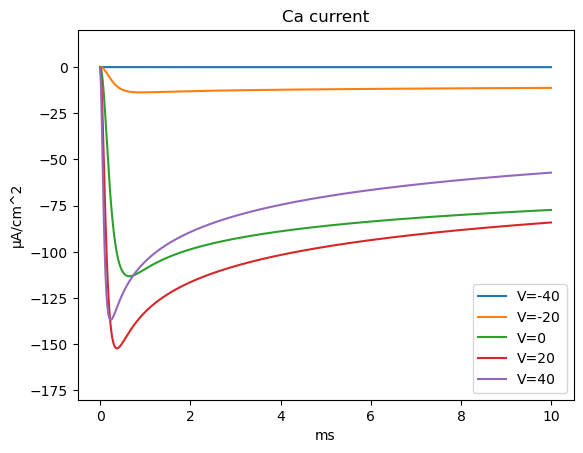

In [6]:
T = 1000
dt = 0.01

for V in [-40, -20, 0, 20, 40]:
    I = jnp.array(Ca().VClamp(Vh=-65, V=V, T=T, dt=dt))
    plt.plot(jnp.arange(T) * dt, I, label=f"V={V}")
    plt.xlabel("ms")
    plt.ylabel("μA/cm^2")
    plt.ylim(-180, 20)
plt.legend()
plt.title("Ca current")

Text(0.5, 1.0, 'Ca Rev. Potential')

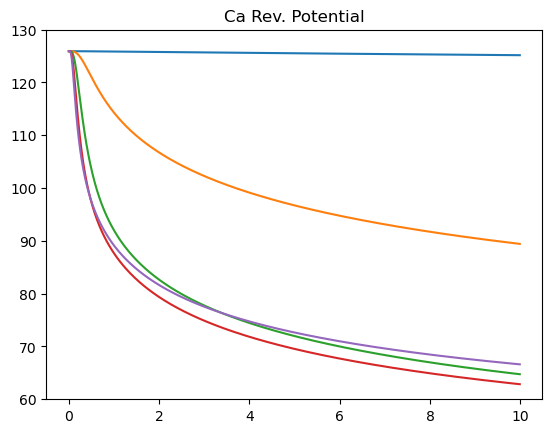

In [7]:
# holding potential
T = 1000
dt = 0.01
Vh = -65

ca = Ca()

for V in [-40, -20, 0, 20, 40]:
    states = ca.channel_states
    params = ca.channel_params
    for _ in range(T * 2):
        states = ca.update_states(states, dt=dt, voltages=Vh, params=params)
        ca.compute_current(states, voltages=Vh, params=params)
        # print(states)

    iCa_holding = ca.compute_current(states, voltages=Vh, params=params)
    vCa_holding = ca.compute_voltage(states, params=params)
    # depolarization
    curs = []
    vols = []

    for i in range(T):
        iCa = ca.compute_current(states, voltages=V, params=params)
        vCa = ca.compute_voltage(states, params=params)
        states = ca.update_states(states, dt=dt, voltages=V, params=params)
        curs.append(iCa)
        vols.append(vCa)

    plt.plot(jnp.arange(T) * dt, vols)
plt.ylim(60, 130)
plt.title("Ca Rev. Potential")